# Labeling Data with minimum features

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier


In [65]:
min_features = pd.read_csv('/Users/sabrinasayed/Documents/GitHub/Data_Center_Sites/Cleaned Data/Minimum_Features.csv', index_col=0)
min_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2979 entries, 0 to 2978
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                2979 non-null   object 
 1   County                               2979 non-null   object 
 2   IXP_Count                            2979 non-null   int64  
 3   Regional Electricity Demand          2979 non-null   object 
 4   Utility Annual Energy Savings (MWh)  2979 non-null   object 
 5   SAIFI Major Events                   2979 non-null   object 
 6   CAIDI w/o Major Events               2979 non-null   float64
 7   CAIDI w/ Major Events                2979 non-null   float64
 8   Commercial Generation Rank           2979 non-null   object 
 9   Total Generation Rank                2979 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 256.0+ KB


## Data Center Site Locations:

In [5]:
# Scraped from different sources

import pandas as pd

data = [
    # Alabama
    ["Birmingham", "AL", 4],
    ["Montgomery", "AL", 2], 
    ["Mobile", "AL", 3],
    ["Auburn", "AL", 1],
    ["Huntsville", "AL", 4],
    ["Bridgeport", "AL", 2],

    # Alaska
    ["Anchorage", "AK", 1],
    ["Prudhoe Bay", "AK", 1],

    # Arizona  
    ["Phoenix", "AZ", 87],
    ["Tucson", "AZ", 8],
    ["Nogales", "AZ", 1],

    # Arkansas
    ["Little Rock", "AR", 3],

    # California
    ["Los Angeles", "CA", 68],
    ["San Jose", "CA", 33],
    ["San Francisco", "CA", 16],
    ["Palo Alto", "CA", 2],
    ["San Diego", "CA", 14],
    ["Santa Clara", "CA", 72],
    ["Irvine", "CA", 14],
    ["Fremont", "CA", 6],
    ["Sacramento", "CA", 22],
    ["Tustin", "CA", 2],
    ["Mountain View", "CA", 1],
    ["San Luis Obispo", "CA", 4],
    ["Modesto", "CA", 2],
    ["Fresno", "CA", 4],
    ["Riverside", "CA", 3],
    ["El Segundo", "CA", 3],
    ["Oakland", "CA", 1],
    ["Emeryville", "CA", 2],
    ["Burbank", "CA", 1],
    ["Goleta", "CA", 1],
    ["Santa Cruz", "CA", 1],
    ["Stockton", "CA", 3],
    ["Bakersfield", "CA", 2],
    ["Hayward", "CA", 2],
    ["Santa Barbara", "CA", 2],
    ["Hawthorne", "CA", 1],
    ["Inland Empire", "CA", 1],
    ["Manchester", "CA", 1],
    ["San Bernardino", "CA", 1],

    # Colorado
    ["Denver", "CO", 46],
    ["Loveland", "CO", 1],
    ["Colorado Springs", "CO", 7],
    ["Fort Collins", "CO", 1],

    # Connecticut
    ["Norwalk", "CT", 1],
    ["Stamford", "CT", 6],
    ["Oxford", "CT", 1],
    ["Norwich", "CT", 20],
    ["Wallingford", "CT", 12],
    ["Groton", "CT", 8],
    ["Hartford", "CT", 4],
    ["Trumbull", "CT", 2],
    ["New Haven", "CT", 4],
    ["Fairfield County", "CT", 1],
    ["Waterbury", "CT", 1],

    # Delaware
    ["Wilmington", "DE", 4],
    ["Newark", "DE", 1],

    # District of Columbia
    ["Washington", "DC", 8],

    # Florida
    ["Tampa", "FL", 23],
    ["Miami", "FL", 41],
    ["Orlando", "FL", 14],
    ["Winter Haven", "FL", 1],
    ["Boca Raton", "FL", 7],
    ["Fort Lauderdale", "FL", 4],
    ["West Palm Beach", "FL", 2],
    ["Gainesville", "FL", 1],
    ["Jacksonville", "FL", 14],
    ["Tallahassee", "FL", 4],
    ["Stuart", "FL", 1],
    ["Fort Myers", "FL", 3],
    ["Melbourne", "FL", 2],
    ["Daytona Beach", "FL", 1],
    ["Deltona", "FL", 1],
    ["Naples", "FL", 1],
    ["Port Saint Lucie", "FL", 1],

    # Georgia
    ["Alpharetta", "GA", 2],
    ["Atlanta", "GA", 86],
    ["Buford", "GA", 1],
    ["Carrollton", "GA", 1],
    ["Columbus", "GA", 1],
    ["Dalton", "GA", 1],
    ["Statesboro", "GA", 1],

    # Hawaii
    ["Honolulu", "HI", 6],
    ["Kapolei", "HI", 1],
    ["Waimea", "HI", 1],

    # Idaho
    ["Coeur d Alene", "ID", 2],
    ["Boise", "ID", 4],

    # Illinois
    ["Chicago", "IL", 138],
    ["Bloomington", "IL", 2],
    ["Champaign", "IL", 2],
    ["Peoria", "IL", 1],
    ["Aurora", "IL", 11],
    ["Rockford", "IL", 1],
    ["Rantoul", "IL", 1],

    # Indiana
    ["Indianapolis", "IN", 18],
    ["South Bend", "IN", 10],
    ["Noblesville", "IN", 1],
    ["Evansville", "IN", 2],
    ["Fort Wayne", "IN", 4],
    ["Hammond", "IN", 1],
    ["Columbus", "IN", 1],
    ["Jeffersonville", "IN", 1],
    ["La Porte", "IN", 1],

    # Iowa
    ["Des Moines", "IA", 20],
    ["Monticello", "IA", 2],
    ["Cedar Rapids", "IA", 2],
    ["Sioux City", "IA", 1],
    ["Cedar Falls", "IA", 2],
    ["Council Bluffs", "IA", 2],
    ["Davenport", "IA", 2],
    ["Lake Park", "IA", 1],
    ["Spencer", "IA", 1],
    ["Waterloo", "IA", 1],

    # Kansas
    ["Kansas City", "KS", 9],
    ["Lenexa", "KS", 2],
    ["Wichita", "KS", 2],
    ["Topeka", "KS", 1],

    # Kentucky
    ["Louisville", "KY", 12],
    ["Lexington", "KY", 2],
    ["Ashland", "KY", 1],
    ["Hopkinsville", "KY", 1],
    ["Ivel", "KY", 1],
    ["Florence", "KY", 2],
    ["Bowling Green", "KY", 1],
    ["Calvert City", "KY", 1],

    # Louisiana
    ["Monroe", "LA", 1],
    ["New Orleans", "LA", 6],
    ["Baton Rouge", "LA", 4],
    ["Shreveport", "LA", 2],

    # Maine
    ["Bangor", "ME", 1],
    ["Brunswick", "ME", 2],
    ["Portland", "ME", 2],
    ["Millinocket", "ME", 1],
    ["Houlton", "ME", 1],

    # Maryland
    ["Baltimore", "MD", 14],
    ["Frederick", "MD", 4],
    ["Beltsville", "MD", 3],
    ["Silver Spring", "MD", 2],
    ["Germantown", "MD", 1],
    ["Laurel", "MD", 2],
    ["Rockville", "MD", 1],

    # Massachusetts
    ["Boston", "MA", 31],
    ["Stoughton", "MA", 1],
    ["Fall River", "MA", 2],
    ["Andover", "MA", 1],
    ["Fitchburg", "MA", 1],
    ["Marlborough", "MA", 6],
    ["Worcester", "MA", 2],
    ["Springfield", "MA", 3],
    ["Acton Boxborough", "MA", 1],
    ["Cambridge", "MA", 1],

    # Michigan
    ["Detroit", "MI", 28],
    ["Grand Rapids", "MI", 9],
    ["Lansing", "MI", 5],
    ["Ann Arbor", "MI", 3],
    ["Battle Creek", "MI", 2],
    ["Alpena", "MI", 1],
    ["Cassopolis", "MI", 1],
    ["Flint", "MI", 1],
    ["Kalamazoo", "MI", 1],
    ["Monroe", "MI", 1],

    # Minnesota
    ["Minneapolis", "MN", 52],
    ["Braham", "MN", 1],
    ["Cambridge", "MN", 1],
    ["Duluth", "MN", 2],
    ["Bemidji", "MN", 1],
    ["Alexandria", "MN", 1],
    ["Saint Paul", "MN", 1],
    ["St. Cloud", "MN", 1],

    # Mississippi
    ["Jackson", "MS", 3],
    ["Hattiesburg", "MS", 1],
    ["Starkville", "MS", 1],

    # Missouri
    ["Kansas City", "MO", 19],
    ["St. Louis", "MO", 17],
    ["Columbia", "MO", 3],
    ["Springfield", "MO", 1],

    # Montana
    ["Billings", "MT", 2],
    ["Bozeman", "MT", 1],

    # Nebraska
    ["Omaha", "NE", 12],
    ["Papillion", "NE", 2],
    ["Lincoln", "NE", 3],
    ["Grand Island", "NE", 1],

    # Nevada
    ["Las Vegas", "NV", 26],
    ["Reno", "NV", 16],

    # New Hampshire
    ["Littleton", "NH", 1],
    ["Manchester", "NH", 5],
    ["Keene", "NH", 1],
    ["Laconia", "NH", 1],
    ["Lebanon", "NH", 1],
    ["Portsmouth", "NH", 1],

    # New Jersey
    ["Newark", "NJ", 8],
    ["Secaucus", "NJ", 11],
    ["Piscataway", "NJ", 14],
    ["Jersey City", "NJ", 5],
    ["North Bergen", "NJ", 1],
    ["Bridgewater", "NJ", 2],
    ["Clifton", "NJ", 3],
    ["Edison", "NJ", 1],
    ["Hackensack", "NJ", 2],
    ["Morris County", "NJ", 4],
    ["Princeton", "NJ", 2],
    ["Newton", "NJ", 1],
    ["New Brunswick", "NJ", 2],
    ["Wall Township", "NJ", 2],
    ["Carteret", "NJ", 1],
    ["Pennsauken", "NJ", 1],
    ["South Brunswick", "NJ", 1],
    ["Totowa", "NJ", 1],

    # New Mexico
    ["Albuquerque", "NM", 6],
    ["Clovis", "NM", 1],
    ["Santa Fe", "NM", 1],
    ["Taos", "NM", 1],

    # New York
    ["New York", "NY", 68],
    ["Rochester", "NY", 4],
    ["Buffalo", "NY", 16],
    ["Albany", "NY", 13],
    ["Garden City", "NY", 1],
    ["Commack", "NY", 1],
    ["Mt. Sinai", "NY", 1],
    ["Islandia", "NY", 1],
    ["Ronkonkoma", "NY", 1],
    ["Setauket", "NY", 1],
    ["Farmingdale", "NY", 1],
    ["Westbury", "NY", 1],
    ["Hicksville", "NY", 1],
    ["Woodbury", "NY", 1],
    ["Melville", "NY", 1],
    ["Syracuse", "NY", 5],
    ["Watertown", "NY", 1],
    ["Potsdam", "NY", 1],
    ["Westchester", "NY", 6],
    ["Plattsburgh", "NY", 1],
    ["Romulus", "NY", 1],
    ["Utica", "NY", 1],
    ["Wappingers Falls", "NY", 1],
    ["Yorktown Heights", "NY", 1],

    # North Carolina
    ["Charlotte", "NC", 32],
    ["Asheville", "NC", 2],
    ["Raleigh", "NC", 11],
    ["Hickory", "NC", 4],
    ["Greensboro", "NC", 5],
    ["Fayetteville", "NC", 1],
    ["Mooresville", "NC", 1],
    ["Sylva", "NC", 1],
    ["Durham", "NC", 2],
    ["Maiden", "NC", 2],
    ["Winston Salem", "NC", 2],
    ["Catawba", "NC", 1],
    ["Goldsboro", "NC", 1],
    ["Marble", "NC", 1],
    ["Roxboro", "NC", 1],

    # North Dakota
    ["Bismarck", "ND", 1],
    ["Fargo", "ND", 4],
    ["Grand Forks", "ND", 2],
    ["Ellendale", "ND", 1],

    # Ohio
    ["Cleveland", "OH", 23],
    ["Columbus", "OH", 103],
    ["Akron", "OH", 5],
    ["Cincinnati", "OH", 22],
    ["Toledo", "OH", 2],
    ["Youngstown", "OH", 1],
    ["Canton", "OH", 2],
    ["Springfield", "OH", 1],
    ["Lebanon", "OH", 1],
    ["Dayton", "OH", 5],
    ["Akron Canton", "OH", 2],
    ["Hannibal", "OH", 1],
    ["Lima", "OH", 1],

    # Oklahoma
    ["Oklahoma City", "OK", 8],
    ["Tulsa", "OK", 16],

    # Oregon
    ["Portland", "OR", 27],
    ["Medford", "OR", 1],
    ["Eugene", "OR", 3],
    ["Bend", "OR", 2],
    ["Hillsboro", "OR", 12],
    ["Baker City", "OR", 1],
    ["Corvallis", "OR", 1],
    ["Boardman", "OR", 30],
    ["Umatilla", "OR", 16],
    ["Hermiston", "OR", 15],
    ["Prineville", "OR", 2],
    ["Bandon", "OR", 1],
    ["The Dalles", "OR", 1],

    # Pennsylvania
    ["Allentown", "PA", 2],
    ["Bethlehem", "PA", 1],
    ["Ebensburg", "PA", 2],
    ["Harrisburg", "PA", 1],
    ["Lancaster", "PA", 1],
    ["Philadelphia", "PA", 27],
    ["Pittsburgh", "PA", 30],
    ["Reading", "PA", 3],
    ["State College", "PA", 1],
    ["Valley Forge", "PA", 1],
    ["Wilkes Barre", "PA", 2],

    # Rhode Island
    ["Providence", "RI", 7],

    # South Carolina
    ["Greenville", "SC", 3],
    ["Seneca", "SC", 1],
    ["Charleston", "SC", 5],
    ["Aiken", "SC", 1],
    ["Spartanburg", "SC", 1],
    ["Columbia", "SC", 3],
    ["Rock Hill", "SC", 2],
    ["Myrtle Beach", "SC", 1],

    # South Dakota
    ["Sioux Falls", "SD", 4],

    # Tennessee
    ["Chattanooga", "TN", 4],
    ["Nashville", "TN", 26],
    ["Knoxville", "TN", 4],
    ["Bristol", "TN", 1],
    ["Jackson", "TN", 1],
    ["Memphis", "TN", 7],
    ["McMinnville", "TN", 1],
    ["Clarksville", "TN", 1],
    ["Lebanon", "TN", 1],

    # Texas
    ["Dallas", "TX", 153],
    ["McAllen", "TX", 4],
    ["San Antonio", "TX", 29],
    ["Houston", "TX", 45],
    ["Austin", "TX", 31],
    ["Bryan", "TX", 1],
    ["El Paso", "TX", 6],
    ["The Woodlands", "TX", 1],
    ["Lubbock", "TX", 2],
    ["Nacogdoches", "TX", 1],
    ["Tyler", "TX", 1],
    ["Laredo", "TX", 3],
    ["Waco", "TX", 3],
    ["Abilene", "TX", 2],
    ["Harlingen", "TX", 2],
    ["Wichita Falls", "TX", 2],
    ["Amarillo", "TX", 1],
    ["Corpus Christi", "TX", 1],
    ["Eagle Pass", "TX", 1],
    ["Fort Stockton", "TX", 1],
    ["Montgomery", "TX", 1],
    ["Pecos", "TX", 1],
    ["San Angelo", "TX", 1],
    ["Stratford", "TX", 1],

    # Utah
    ["Salt Lake City", "UT", 23],
    ["Orem", "UT", 3],
    ["St George", "UT", 1],
    ["Ogden", "UT", 1],
    ["St. George", "UT", 1],

    # Vermont
    ["Burlington", "VT", 2],
    ["Stowe", "VT", 1],

    # Virginia
    ["Ashburn", "VA", 133],
    ["Reston", "VA", 6],
    ["Manassas", "VA", 77],
    ["Vienna", "VA", 9],
    ["Sterling", "VA", 99],
    ["Chantilly", "VA", 21],
    ["Richmond", "VA", 25],
    ["Herndon", "VA", 10],
    ["Lexington", "VA", 1],
    ["Middletown", "VA", 1],
    ["Gainesville", "VA", 27],
    ["Dulles", "VA", 23],
    ["Norfolk", "VA", 6],
    ["Harrisonburg", "VA", 2],
    ["Roanoke", "VA", 1],
    ["Bristow", "VA", 19],
    ["Culpeper", "VA", 15],
    ["South Riding", "VA", 5],
    ["Fredericksburg", "VA", 1],
    ["Duffield", "VA", 1],
    ["Wise", "VA", 1],

    # Washington
    ["Bellevue", "WA", 2],
    ["Bellingham", "WA", 2],
    ["Moses Lake", "WA", 2],
    ["Pasco", "WA", 1],
    ["Quincy", "WA", 4],
    ["Seattle", "WA", 56],
    ["Spokane", "WA", 6],
    ["Tacoma", "WA", 9],
    ["Walla Walla", "WA", 5],
    ["Wenatchee", "WA", 5],

    # West Virginia
    ["Bridgeport", "WV", 2],
    ["Berkeley Springs", "WV", 1],
    ["Morgantown", "WV", 1],
    ["Charleston", "WV", 3],

    # Wisconsin
    ["Milwaukee", "WI", 18],
    ["Madison", "WI", 8],
    ["Wisconsin Rapids", "WI", 1],
    ["Kenosha", "WI", 5],
    ["Appleton", "WI", 2],
    ["Green Bay", "WI", 3],
    ["Wausau", "WI", 1],
    ["Eau Claire", "WI", 1],
    ["Marshfield", "WI", 1],

    # Wyoming
    ["Cheyenne", "WY", 8],
    ["Casper", "WY", 1],
    ["Evanston", "WY", 1],
    ["Afton", "WY", 1]
]

# Create DataFrame
data_centers = pd.DataFrame(data, columns=['City', 'State', 'Number_of_Data_Centers'])

# Sort by State and Number of Data Centers (descending)
data_centers= data_centers.sort_values(['State', 'Number_of_Data_Centers'], ascending=[True, False])

data_centers.head(30)

,City,State,Number_of_Data_Centers
6,Anchorage,AK,1
7,Prudhoe Bay,AK,1
0,Birmingham,AL,4
4,Huntsville,AL,4
2,Mobile,AL,3
1,Montgomery,AL,2
5,Bridgeport,AL,2
3,Auburn,AL,1
11,Little Rock,AR,3
8,Phoenix,AZ,87


In [6]:
min_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2979 entries, 0 to 2978
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                2979 non-null   object 
 1   County                               2979 non-null   object 
 2   IXP_Count                            2979 non-null   int64  
 3   Regional Electricity Demand          2979 non-null   object 
 4   Utility Annual Energy Savings (MWh)  2979 non-null   object 
 5   SAIFI Major Events                   2979 non-null   object 
 6   CAIDI w/o Major Events               2979 non-null   float64
 7   CAIDI w/ Major Events                2979 non-null   float64
 8   Commercial Generation Rank           2979 non-null   object 
 9   Total Generation Rank                2979 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 256.0+ KB


In [7]:
def assign_ixp_count(count):
    """
    Categorize IXP counts based on industry standards:
    - High: 50+ IXPs indicates major connectivity hub (like major metro areas)
    - Moderate: 10-49 IXPs indicates good regional connectivity
    - Low: <10 IXPs indicates limited connectivity
    """
    if count >= 50:  # Major connectivity hubs
        return 'High'
    elif count >= 10:  # Regional connectivity centers
        return 'Moderate'
    else:
        return 'Low'
    
min_features['IXP_Count'] = min_features['IXP_Count'].apply(assign_ixp_count)
min_features['IXP_Count'].value_counts()

IXP_Count
Moderate    1965
Low         1014
Name: count, dtype: int64

In [8]:
min_features['IXP_Count'].astype('category')
min_features.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2979 entries, 0 to 2978
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   State                                2979 non-null   object 
 1   County                               2979 non-null   object 
 2   IXP_Count                            2979 non-null   object 
 3   Regional Electricity Demand          2979 non-null   object 
 4   Utility Annual Energy Savings (MWh)  2979 non-null   object 
 5   SAIFI Major Events                   2979 non-null   object 
 6   CAIDI w/o Major Events               2979 non-null   float64
 7   CAIDI w/ Major Events                2979 non-null   float64
 8   Commercial Generation Rank           2979 non-null   object 
 9   Total Generation Rank                2979 non-null   object 
dtypes: float64(2), object(8)
memory usage: 256.0+ KB


In [9]:
def assign_cai_rating(cai):
    """
    Categorize CAIDI (Customer Average Interruption Duration Index) without major events
    Based on IEEE Standard 1366-2012 and industry benchmarks:
    - Low: ≤ 90 minutes (excellent reliability)
    - Moderate: 90-120 minutes (average performance)
    - High: > 120 minutes (needs improvement)
    """
    if cai <= 90:  # Industry benchmark for excellent performance
        return 'Low'
    elif cai <= 120:  # Typical industry average
        return 'Moderate'
    else:
        return 'High'
    
min_features['CAIDI w/o Major Events'] = min_features['CAIDI w/o Major Events'].apply(assign_cai_rating)

def assign_caiME_rating(cai):
    """
    Categorize CAIDI with major events
    Thresholds are higher due to inclusion of major events:
    - Low: ≤ 150 minutes (robust system)
    - Moderate: 150-240 minutes (typical during events)
    - High: > 240 minutes (significant impact from events)
    """
    if cai <= 150:  # Good performance even with major events
        return 'Low'
    elif cai <= 240:  # Reasonable performance during major events
        return 'Moderate'
    else:
        return 'High'

min_features['CAIDI w/ Major Events'] = min_features['CAIDI w/ Major Events'].apply(assign_caiME_rating)

In [10]:
min_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2979 entries, 0 to 2978
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                2979 non-null   object
 1   County                               2979 non-null   object
 2   IXP_Count                            2979 non-null   object
 3   Regional Electricity Demand          2979 non-null   object
 4   Utility Annual Energy Savings (MWh)  2979 non-null   object
 5   SAIFI Major Events                   2979 non-null   object
 6   CAIDI w/o Major Events               2979 non-null   object
 7   CAIDI w/ Major Events                2979 non-null   object
 8   Commercial Generation Rank           2979 non-null   object
 9   Total Generation Rank                2979 non-null   object
dtypes: object(10)
memory usage: 256.0+ KB


In [11]:
min_features = min_features.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
min_features.head()


,State,County,IXP_Count,Regional Electricity Demand,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank
0,AK,Anchorage Municipality County,Low,Moderate,Unknown,High,High,Low,High,Low
1,AK,Kenai Peninsula County,Low,Moderate,Unknown,High,High,Low,High,Low
2,AK,Kenai Peninsula Borough County,Low,Moderate,Unknown,High,High,Low,High,Low
3,AL,Montgomery County,Low,Low,Low,Moderate,High,Moderate,Low,High
4,AL,Lee County,Low,Low,Low,Moderate,High,Moderate,Low,High


In [12]:
# 1. Standardize county names by adding 'County' if missing
min_features['County'] = min_features['County'].apply(lambda x: x + ' County' if not x.endswith('County') else x)


In [13]:
min_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2979 entries, 0 to 2978
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                2979 non-null   object
 1   County                               2979 non-null   object
 2   IXP_Count                            2979 non-null   object
 3   Regional Electricity Demand          2979 non-null   object
 4   Utility Annual Energy Savings (MWh)  2979 non-null   object
 5   SAIFI Major Events                   2979 non-null   object
 6   CAIDI w/o Major Events               2979 non-null   object
 7   CAIDI w/ Major Events                2979 non-null   object
 8   Commercial Generation Rank           2979 non-null   object
 9   Total Generation Rank                2979 non-null   object
dtypes: object(10)
memory usage: 256.0+ KB


In [14]:
min_features.head()

,State,County,IXP_Count,Regional Electricity Demand,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank
0,AK,Anchorage Municipality County,Low,Moderate,Unknown,High,High,Low,High,Low
1,AK,Kenai Peninsula County,Low,Moderate,Unknown,High,High,Low,High,Low
2,AK,Kenai Peninsula Borough County,Low,Moderate,Unknown,High,High,Low,High,Low
3,AL,Montgomery County,Low,Low,Low,Moderate,High,Moderate,Low,High
4,AL,Lee County,Low,Low,Low,Moderate,High,Moderate,Low,High


In [15]:
min_features.isna().value_counts()

State  County  IXP_Count  Regional Electricity Demand  Utility Annual Energy Savings (MWh)  SAIFI Major Events  CAIDI w/o Major Events  CAIDI w/ Major Events  Commercial Generation Rank  Total Generation Rank
False  False   False      False                        False                                False               False                   False                  False                       False                    2979
Name: count, dtype: int64

# Save data centers data

In [16]:
data_centers.to_csv('/Users/sabrinasayed/Documents/GitHub/Data_Center_Sites/Data/data_centers.csv')

## Labeling Data

In [21]:
df = min_features.copy()

In [26]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np


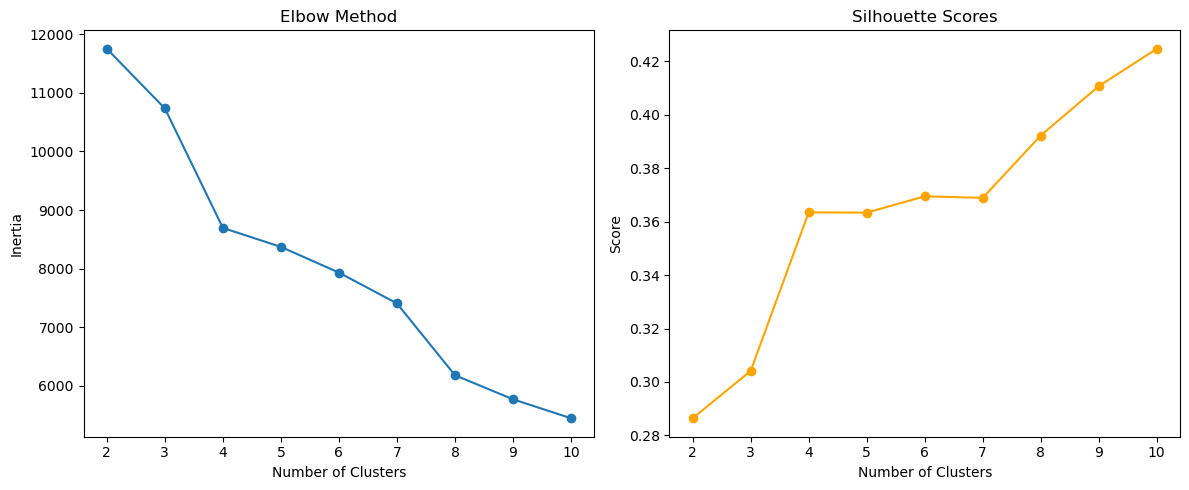

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

X = df

# Preprocess data

# One-Hot Encoding for Categorical Features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(df)
feature_names = encoder.get_feature_names_out()

inertia = []
silhouette_scores = []
cluster_range = range(2, 11)

# Clustering Analysis
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(encoded_data, kmeans.labels_))

# Plot Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


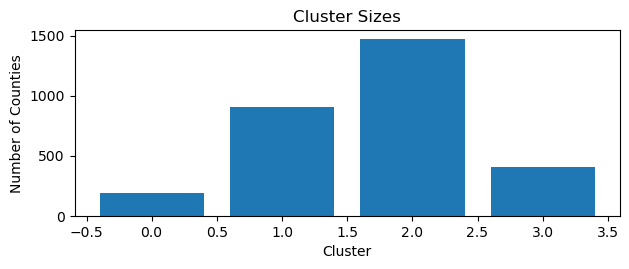


Cluster Analysis:
--------------------------------------------------


In [40]:

# Select optimal number of clusters (based on elbow/silhouette)
optimal_clusters = 4  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)

# Add cluster labels to original dataframe
df['Cluster'] = cluster_labels

# Analyze cluster characteristics
plt.subplot(2, 2, (3, 4))
cluster_sizes = df['Cluster'].value_counts().sort_index()
plt.bar(range(optimal_clusters), cluster_sizes)
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Counties')

plt.tight_layout()
plt.show()

# Print cluster characteristics
print("\nCluster Analysis:")
print("-" * 50)


In [41]:
# Print cluster characteristics
print("\nCluster Analysis:")
print("-" * 50)

for cluster in range(optimal_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    print(f"\nCluster {cluster} ({len(cluster_data)} counties)")
    print("-" * 30)
    
    # Analyze categorical features
    for col in df.select_dtypes(include=['object']).columns:
        if col != 'Cluster':
            print(f"\n{col}:")
            print(cluster_data[col].value_counts().head(3))
            
    # Calculate feature importance
    cluster_center = kmeans.cluster_centers_[cluster]
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(cluster_center)
    }).sort_values('Importance', ascending=False)
    
    print("\nTop distinguishing features:")
    print(feature_importance.head(5))
    print("\n" + "="*50)



Cluster Analysis:
--------------------------------------------------

Cluster 0 (192 counties)
------------------------------

State:
State
WA    119
GA     60
KY      5
Name: count, dtype: int64

County:
County
King County      102
Fulton County     30
Dekalb County     30
Name: count, dtype: int64

IXP_Count:
IXP_Count
Low    192
Name: count, dtype: int64

Regional Electricity Demand:
Regional Electricity Demand
Moderate    120
Low          61
Unknown       7
Name: count, dtype: int64

Utility Annual Energy Savings (MWh):
Utility Annual Energy Savings (MWh)
Low         125
Moderate     49
High         17
Name: count, dtype: int64

SAIFI Major Events:
SAIFI Major Events
Moderate    187
Low           4
High          1
Name: count, dtype: int64

CAIDI w/o Major Events:
CAIDI w/o Major Events
High        125
Moderate     67
Name: count, dtype: int64

CAIDI w/ Major Events:
CAIDI w/ Major Events
Low         121
Moderate     65
High          6
Name: count, dtype: int64

Commercial Generat

# Clustering with DBSCAN

In [43]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances

# Load dataset
df

# Step 1: One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(df)

# Step 2: Compute Distance Matrix 
# You can skip this if using DBSCAN with Euclidean distance
distance_matrix = pairwise_distances(encoded_data, metric='hamming')

# Step 3: Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='precomputed')
cluster_labels = dbscan.fit_predict(distance_matrix)

# Add cluster labels to the original DataFrame
df['Cluster'] = cluster_labels


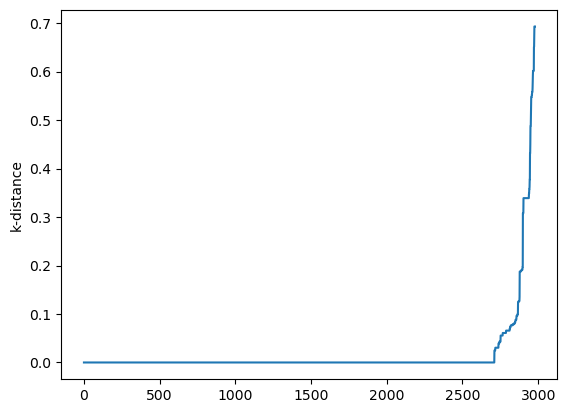

In [44]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(distance_matrix)
distances, _ = neigh.kneighbors(distance_matrix)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.ylabel('k-distance')
plt.show()


In [49]:
# Try DBSCAN with eps around the elbow point
dbscan = DBSCAN(eps=0.15, min_samples=5, metric='precomputed')
cluster_labels = dbscan.fit_predict(distance_matrix)

# Check the distribution of labels
print("Number of clusters:", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))
print("Number of noise points:", list(cluster_labels).count(-1))

Number of clusters: 1
Number of noise points: 0


In [51]:
pip install gower

Note: you may need to restart the kernel to use updated packages.


In [54]:
# Gower Distance
import gower

# Calculate distance matrix using gower.gower_matrix()
distance_matrix = gower.gower_matrix(df)

# Step 2: Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5, metric='precomputed')
cluster_labels = dbscan.fit_predict(distance_matrix)

# Add cluster labels to the DataFrame
df['Cluster'] = cluster_labels

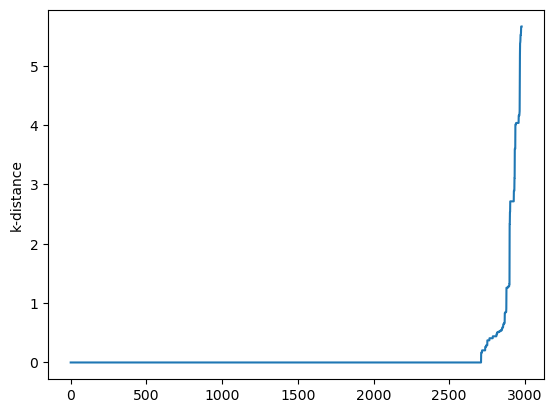

In [55]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(distance_matrix)
distances, _ = neigh.kneighbors(distance_matrix)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.ylabel('k-distance')
plt.show()


In [60]:
# Try DBSCAN with eps around the elbow point
dbscan = DBSCAN(eps=0.35, min_samples=5, metric='precomputed')
cluster_labels = dbscan.fit_predict(distance_matrix)

# Check the distribution of labels
print("Number of clusters:", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))
print("Number of noise points:", list(cluster_labels).count(-1))

Number of clusters: 3
Number of noise points: 8


In [61]:
df.drop(columns=['Cluster'], inplace=True)
df.head()


,State,County,IXP_Count,Regional Electricity Demand,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank,Target
0,AK,Anchorage Municipality County,Low,Moderate,Unknown,High,High,Low,High,Low,Medium Suitability
1,AK,Kenai Peninsula County,Low,Moderate,Unknown,High,High,Low,High,Low,Medium Suitability
2,AK,Kenai Peninsula Borough County,Low,Moderate,Unknown,High,High,Low,High,Low,Medium Suitability
3,AL,Montgomery County,Low,Low,Low,Moderate,High,Moderate,Low,High,Low Suitability
4,AL,Lee County,Low,Low,Low,Moderate,High,Moderate,Low,High,Low Suitability


In [62]:
df['Target'].value_counts()

Target
Low Suitability       1472
Medium Suitability    1315
High Suitability       192
Name: count, dtype: int64

In [31]:
df.rename(columns={'Label': 'Target'}, inplace=True)

In [32]:
df[df['Target'] == 'High Suitability']

,State,County,IXP_Count,Regional Electricity Demand,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank,Target
965,DC,District Of Columbia County,Low,High,Moderate,Low,Moderate,Moderate,Unknown,Unknown,High Suitability
966,DC,District of Columbia County,Low,High,Moderate,Low,Moderate,Moderate,Unknown,Unknown,High Suitability
967,DC,District Of Columbia County,Low,High,Moderate,Low,Moderate,Moderate,Unknown,Unknown,High Suitability
968,DC,District of Columbia County,Low,High,Moderate,Low,Moderate,Moderate,Unknown,Unknown,High Suitability
1109,GA,Fulton County,Low,Low,High,Moderate,Moderate,Moderate,Unknown,Unknown,High Suitability
...,...,...,...,...,...,...,...,...,...,...,...
2959,WA,King County,Low,Moderate,Moderate,Moderate,High,Low,Unknown,Unknown,High Suitability
2960,WA,King County,Low,Moderate,Moderate,Moderate,High,Low,Unknown,Unknown,High Suitability
2961,WA,King County,Low,Moderate,Moderate,Moderate,High,Low,Unknown,Unknown,High Suitability
2962,WA,King County,Low,Moderate,Moderate,Moderate,High,Low,Unknown,Unknown,High Suitability


### Scoring and Labeling is done

In [43]:
min_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2060 entries, 60 to 9555
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                2060 non-null   object
 1   County                               2060 non-null   object
 2   IXP_Count                            2060 non-null   object
 3   Region                               2060 non-null   object
 4   Regional Electricity Demand          2060 non-null   object
 5   Utility Annual Energy Savings (MWh)  2060 non-null   object
 6   SAIFI Major Events                   2060 non-null   object
 7   CAIDI w/o Major Events               2060 non-null   object
 8   CAIDI w/ Major Events                2060 non-null   object
 9   Commercial Generation Rank           2060 non-null   object
 10  Total Generation Rank                2060 non-null   object
 11  Suitability                          2060 non-n

In [44]:
min_features.head()

,State,County,IXP_Count,Region,Regional Electricity Demand,Utility Annual Energy Savings (MWh),SAIFI Major Events,CAIDI w/o Major Events,CAIDI w/ Major Events,Commercial Generation Rank,Total Generation Rank,Suitability
60,AL,Autauga County,Low,SE,Low,Low,Moderate,High,Moderate,Low,High,Unsuitable
62,AL,Baldwin County,Low,SE,Low,Low,Moderate,High,Moderate,Low,High,Unsuitable
64,AL,Barbour County,Low,SE,Low,Low,Moderate,High,Moderate,Low,High,Unsuitable
66,AL,Bibb County,Low,SE,Low,Low,Moderate,High,Moderate,Low,High,Unsuitable
68,AL,Blount County,Low,SE,Low,Low,Moderate,High,Moderate,Low,High,Unsuitable


# Model with CatBoost

In [45]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = min_features.drop(columns=['Suitability'])
y = min_features['Suitability']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [46]:
# Define categorical features
categorical_features = ['State', 'County', 'IXP_Count', 'Region', 
                       'Regional Electricity Demand', 'Utility Annual Energy Savings (MWh)',
                       'SAIFI Major Events', 'CAIDI w/o Major Events', 'CAIDI w/ Major Events',
                       'Commercial Generation Rank', 'Total Generation Rank']

# Initialize and train the model with categorical_features parameter
model = CatBoostClassifier(iterations=100, 
                          depth=10, 
                          learning_rate=0.1, 
                          random_seed=42,
                          cat_features=categorical_features)

model.fit(X_train, y_train)

0:	learn: 0.6151408	total: 104ms	remaining: 10.3s
1:	learn: 0.5422718	total: 110ms	remaining: 5.39s
2:	learn: 0.4765893	total: 111ms	remaining: 3.59s
3:	learn: 0.4258326	total: 142ms	remaining: 3.41s
4:	learn: 0.3792150	total: 147ms	remaining: 2.79s
5:	learn: 0.3414748	total: 156ms	remaining: 2.44s
6:	learn: 0.3062212	total: 159ms	remaining: 2.12s
7:	learn: 0.2752734	total: 166ms	remaining: 1.91s
8:	learn: 0.2490602	total: 170ms	remaining: 1.72s
9:	learn: 0.2243970	total: 172ms	remaining: 1.55s
10:	learn: 0.2030884	total: 173ms	remaining: 1.4s
11:	learn: 0.1864188	total: 183ms	remaining: 1.34s
12:	learn: 0.1688650	total: 185ms	remaining: 1.24s
13:	learn: 0.1530679	total: 188ms	remaining: 1.15s
14:	learn: 0.1396943	total: 191ms	remaining: 1.08s
15:	learn: 0.1278495	total: 192ms	remaining: 1.01s
16:	learn: 0.1168835	total: 194ms	remaining: 949ms
17:	learn: 0.1069307	total: 195ms	remaining: 890ms
18:	learn: 0.1000927	total: 220ms	remaining: 939ms
19:	learn: 0.0936336	total: 244ms	remainin

In [47]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Suitable       1.00      1.00      1.00       131
  Unsuitable       1.00      1.00      1.00       281

    accuracy                           1.00       412
   macro avg       1.00      1.00      1.00       412
weighted avg       1.00      1.00      1.00       412



# Tuning with GridSearchCV

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model = CatBoostClassifier(cat_features=categorical_features)
pipeline = Pipeline([
    ('model', model)
])

param_grid = {
    'model__iterations': [100, 200],
    'model__depth': [5, 6 , 8, 10],
    'model__learning_rate': [0.001, 0.01, 0.1],
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

0:	learn: 0.6922861	total: 11.9ms	remaining: 1.18s
1:	learn: 0.6914351	total: 29.3ms	remaining: 1.43s
2:	learn: 0.6906019	total: 35.6ms	remaining: 1.15s
3:	learn: 0.6897814	total: 38.6ms	remaining: 927ms
4:	learn: 0.6889299	total: 41.6ms	remaining: 791ms
5:	learn: 0.6880593	total: 45.4ms	remaining: 711ms
6:	learn: 0.6871936	total: 51.4ms	remaining: 683ms
7:	learn: 0.6863219	total: 58.2ms	remaining: 669ms
8:	learn: 0.6854758	total: 63ms	remaining: 637ms
9:	learn: 0.6846710	total: 79.2ms	remaining: 713ms
10:	learn: 0.6838071	total: 95.3ms	remaining: 771ms
11:	learn: 0.6829578	total: 103ms	remaining: 756ms
12:	learn: 0.6821316	total: 109ms	remaining: 730ms
13:	learn: 0.6812881	total: 112ms	remaining: 690ms
14:	learn: 0.6804712	total: 115ms	remaining: 654ms
15:	learn: 0.6796050	total: 119ms	remaining: 623ms
16:	learn: 0.6788142	total: 125ms	remaining: 610ms
17:	learn: 0.6779964	total: 131ms	remaining: 596ms
18:	learn: 0.6771773	total: 134ms	remaining: 571ms
19:	learn: 0.6763126	total: 144m